In [1]:
import re

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# データの読み込み
path = "../stock_price.csv"
# 読み込み時に日付けをdatatimeオブジェクトに変換するように変更
df = pd.read_csv(path, parse_dates=["日付け"])

# 前処理
df = df.rename(
    columns={
        "日付け": "Date",
        "終値": "Close",
        "始値": "Open",
        "高値": "High",
        "安値": "Low",
        "出来高": "Volume",
        "変化率 %": "Change",
    }
)

symbols = set()
for value in df["Volume"]:
    symbol = re.sub(r"\d*\.?\d*", "", str(value))
    if symbol:
        symbols.add(symbol)


def convert_volume(value):
    number = float(re.sub(r"[BM]", "", str(value)))
    if "B" in str(value):
        return number * 1000000000
    elif "M" in str(value):
        return number * 1000000
    else:
        return number


features = df.copy()
# 重要: データの順番を逆転
features = features.iloc[::-1].reset_index(drop=True)
features["Volume"] = features["Volume"].apply(convert_volume)
features["Change"] = features["Change"].str.replace("%", "").astype(float)

features = features.values
dates = features[:, 0].reshape(-1, 1)
values = features[:, 1:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
values_scaled = scaler.transform(values)

In [3]:
# モデル定義
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        """
        一層LSTMを用いたseq2one時系列予測モデル

            (batch, len_seq, input_size) -> (batch, input_size)

        Params:
            input_size: int 入力のチャネル数
            hidden_size: int 内部隠れ変数の次元
            output_size: int 出力のチャネル数
        """
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, batch_first=True
        )
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        x, _ = self.lstm(input_seq)
        x_last = x[:, -1, :]
        x = self.linear(x_last)

        return x

In [4]:
# サンプルを生成するための補助関数
# 第一列に目的変数がある二次元データからシーケンスを作成
def get_seq(data, timestep):
    if len(data) < timestep:
        raise ValueError("invalid timestep")

    X = []
    y = []

    for i in range(len(data) - timestep - 1):
        # 入力: iからi+timestep-1までのすべての特徴量
        X.append(data[i : i + timestep, :])
        # ターゲット: i+timestep番目の目的変数
        y.append(data[i + timestep, 0])

    # y: reshapeしないと(n)
    X, y = np.array(X), np.array(y).reshape(-1, 1)

    return X, y

In [5]:
# モデル、誤差関数、最適化メソッドを定義
model = LSTMModel(input_size=6)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 検証より、n=10を採用
len_seq = 10

# 学習用データの準備
X, y = get_seq(values_scaled, len_seq)
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

train_size = int(len(X) * 0.70)
valid_size = int(len(X) * 0.15)
X_train, X_valid, X_test = (
    X[:train_size, :],
    X[train_size : train_size + valid_size, :],
    X[train_size + valid_size :, :],
)
y_train, y_valid, y_test = (
    y[:train_size, :],
    y[train_size : train_size + valid_size, :],
    y[train_size + valid_size :, :],
)
# データローダーの作成
batch_size = 32
dataset_train = TensorDataset(X_train, y_train)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


10: 0.014895668993631261
20: 0.017729442147356167
30: 0.01404309505596757
40: 0.013339841701053956
50: 0.013853650480086799
60: 0.013326905565008929
70: 0.012639714615033881
80: 0.01281145677967288
90: 0.01205361947450001
100: 0.012733442578337417
110: 0.01313142373055598
120: 0.012148143875720052
130: 0.012016307528028847
140: 0.012399184112837247
150: 0.012042208742968796
160: 0.012000627244560746
170: 0.011967135977101861
180: 0.011817791912108078
190: 0.011979587631075539
200: 0.011981500814727042


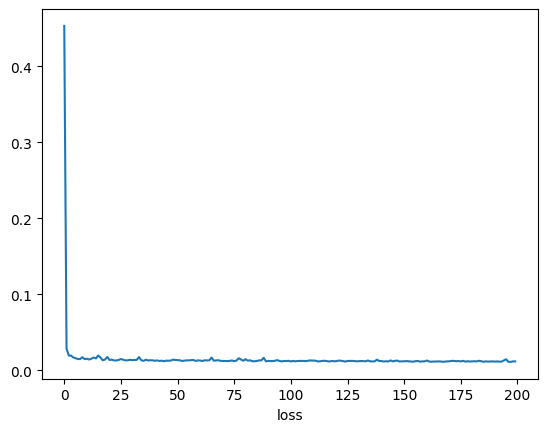

In [6]:
epochs = 200
losses = []

# ミニバッチ学習
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in loader_train:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    losses.append(total_loss)

    if (epoch + 1) % 10 == 0:
        print(f"{epoch + 1}: {total_loss}")

plt.plot(losses)
plt.xlabel("loss")
plt.show()

In [7]:
# モデルの評価
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

y_test = y_test.numpy()

# 1次元の予測値を3次元に拡張して逆変換
_y_pred = np.zeros((len(y_pred), 6))
_y_pred[:, 0] = y_pred.flatten()
y_pred_inverted = scaler.inverse_transform(_y_pred)[:, 0:1]

# テストデータも同様
_y_test = np.zeros((len(y_test), 6))
_y_test[:, 0] = y_test.flatten()
y_test_inverted = scaler.inverse_transform(_y_test)[:, 0:1]

# 誤差計算
# MSE; Mean Squared Error, 平均二乗誤差
mse_inv = np.mean((y_pred_inverted - y_test_inverted) ** 2)
# RMSE; Root Mean Squared, ErrorMSEの平方根
rmse_inv = np.sqrt(mse_inv)
# MAPE; Mean Absolute Percentage Error, 平均絶対パーセント誤差
mape = np.mean(np.abs((y_pred_inverted - y_test_inverted) / y_test_inverted))

mse_inv.item(), rmse_inv.item(), mape.item()

(3.726218822962154, 1.930341633743145, 0.011388468506056017)

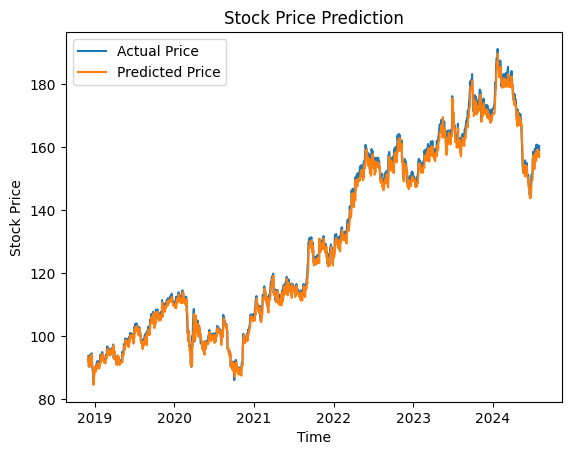

In [8]:
dates_test = dates[-(len(y_test_inverted)) :, :]
plt.plot(dates_test, y_test_inverted, label="Actual Price")
plt.plot(dates_test, y_pred_inverted, label="Predicted Price")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction")
plt.show()

In [9]:
"""
モデルの保存
path = "lstm.pth"
torch.save(model.state_dict(), path)
"""

'\nモデルの保存\npath = "lstm.pth"\ntorch.save(model.state_dict(), path)\n'